In [2]:
from read_telescope import VAtmosAbsorption, extract_data_from_file, filter_photons, simulate_davies_cotton_optics, read_particle_file, convert_coordinates_to_shower
from camera_response import noise_function, camera_response_function
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm

def make_2d_histogram_consistent(x, y, x_edges, y_edges):
    """
    Create 2D histogram with consistent bin edges
    """
    if len(x) == 0 or len(y) == 0:
        # Return empty histogram with correct shape
        return np.zeros((len(y_edges)-1, len(x_edges)-1))
    
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    return heatmap.T  # Transpose to match the orientation of the data

def Camera_Response(T_photon, x_base, y_base, w, noise=True):
    if len(T_photon) > 0:
        T_photon = T_photon - T_photon.min()  # Normalize time to start at zero
        delta_t = 10 # ns
        N = int(T_photon.max() / delta_t) + 1
        t_min = 0
        t_max = T_photon.max()
        n_window = int(np.ceil((t_max - t_min) / delta_t))
        # Pre-allocate lists
        T = [] # List to store time windows
        X = [] # List to store x coordinates
        Y = [] # List to store y coordinates
        W = [] # List to store wavelengths

        # Use numpy's digitize for efficient binning
        time_edges = np.arange(t_min, t_max + delta_t, delta_t)
        bin_indices = np.digitize(T_photon, time_edges) - 1

        # Group data by time windows
        for i in range(n_window):
            mask = (bin_indices == i)
            T.append(T_photon[mask])
            X.append(x_base[mask])
            Y.append(y_base[mask])
            W.append(w[mask])
            # Define global bin edges
        n_bins = 16
        r_cam = 6
        x_min, x_max = -r_cam, r_cam
        y_min, y_max =  -r_cam, r_cam
        # Add small padding to avoid edge effects
        x_padding = (x_max - x_min) * 0.01
        y_padding = (y_max - y_min) * 0.01

        # Create consistent bin edges for all histograms
        global_x_edges = np.linspace(x_min - x_padding, x_max + x_padding, n_bins + 1)
        global_y_edges = np.linspace(y_min - y_padding, y_max + y_padding, n_bins + 1)

        H = [] # List to store histograms
        Times = [] # List to store corresponding times
        center_times = time_edges[1:] - delta_t/2  # Fixed: should be delta_t/2, not 5
        for i in range(len(X)):
            h2d = make_2d_histogram_consistent(X[i], Y[i], global_x_edges, global_y_edges)
            # Apply your Trigger condition
            if (h2d >= 1).any(): #At least one bin must have a count >= 1
                H.append(h2d)
                Times.append(center_times[i])
        if len(H) > 0: 
            # Convert to numpy arrays for easier manipulation
            H = np.array(H) 
            if noise == True:
                Noise = noise_function(H, lambda_fit=0.74)  # Generate noise for the histograms
                H += Noise  # Add noise to the histograms
            else:
                Noise = None
            Times = np.array(Times)
            # Camera response function to weight the histograms
            h = H.copy()
            for i in range(len(Times)):
                weight = camera_response_function(np.array(Times), Times[i])
                h += weight[:, np.newaxis, np.newaxis] * H[i]
            return h, H, Times, Noise #H is no camera response, h is with camera response
        else:
            print("No histograms created. Check your data and filter conditions.")
            return None, None, None, None
    else:
        print("No photons found in the data.")
        return None, None, None, None

def Monte_Carlos_Avg(zenith, production_height="20.E5", gen_radi = "1500", noise=True, E_mag = 6, particle = 6, N = 10):
    # Define the parameters
    #zenith = 88  #  available: 0 30 60 88 degrees
      # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
      # 5 is mu+, 6 is mu-
    #production_height = "20.E5"  # available: 10.E5 20.E5 cm
      # telescope radius in cm, available:  1500 cm
    Store_Events = []  # Store the results of each Monte Carlo iteration
    for i in range(N):
        id = random.randint(1, 50)  # Randomly select an ID for each iteration
        ID = [id]
        input_files = [
            f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_h{production_height}_r{gen_radi}._Trinity/out_sib23d-pId{particle}-En1.00E{E_mag}-{zenith}./OUTPUT_1.00E{E_mag}_{particle}_{zenith}._{100+i}/telescope.dat"
            for i in ID
        ]
        atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
        ran_val = random.randint(0, 10000)  # Random seed for reproducibility
        atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
        T_photon, x_base, y_base, w, Zem, cos_x, cos_y = extract_data_from_file(input_files, atmos, R=float(gen_radi), filter=False, optics=False)
        #off set the x and y positions of the shower to the center of the camera randomly
        x_base = x_base - np.random.uniform(-150, 150)  # Randomly offset x position
        y_base = y_base - np.random.uniform(-150, 150)  # Randomly offset y position
        # Apply the Davies-Cotton optics simulation
        x_base, y_base, w, Zem, T_photon, incident_angles, cos_x, cos_y = simulate_davies_cotton_optics(
                    x_base, y_base, w, Zem, T_photon, cos_x, cos_y, zenith,
                    R=150, r_cam=6, 
                    get_mirror_photons=False,
                    plotting=False
                )
        #Apply the atmospheric absorption and photon detection efficiency:
        zenith_rad = np.radians(zenith)
        atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
        ran_val = random.randint(0, 10000)  # Random seed for reproducibility
        atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
        x_base, y_base, T_photon, w, Zem, mask = filter_photons(x_base, y_base, T_photon, w, Zem, zenith_rad, atmos, filter=True)
        T_photon = np.array(T_photon)
        # Call the camera response function
        h, _, _, _ = Camera_Response(T_photon, x_base, y_base, w, noise=noise)
        Trigger_events = sum(h[np.where(h>=20)]) if h is not None else 0
        Store_Events.append(Trigger_events)  # Store the number of triggered events for this iteration
    return Store_Events

def calculate_detection_efficiency(pe_counts, threshold=20, alpha=0.05, n_bootstrap=10000):
    """
    Calculates Poisson-based detection efficiency and its uncertainty via:
      1. Delta-method (analytic)
      2. Bootstrap resampling

    Parameters:
    - pe_counts: list or array of observed PE counts
    - threshold: integer threshold for detection (default=20)
    - alpha: significance level for CI (default=0.05 for 95% CI)
    - n_bootstrap: number of bootstrap samples (default=10000)

    Returns:
    - lambda_hat: estimated mean PE count
    - p_det: detection efficiency P(N>=threshold | lambda_hat)
    - ci_delta: (lower, upper) CI via delta method
    - ci_bootstrap: (lower, upper) CI via bootstrap
    """
    pe = np.array(pe_counts)
    N = len(pe)
    lambda_hat = pe.mean()

    # Poisson-based detection probability
    p_det = 1 - poisson.cdf(threshold - 1, lambda_hat)

    # Bootstrap CI
    rng = np.random.default_rng()
    p_boot = []
    for _ in range(n_bootstrap):
        sample = rng.choice(pe, size=N, replace=True)
        lambda_b = sample.mean()
        p_b = 1 - poisson.cdf(threshold - 1, lambda_b)
        p_boot.append(p_b)
    lower = p_det - np.percentile(p_boot, 100 * alpha/2)
    upper = np.percentile(p_boot, 100 * (1 - alpha/2)) - p_det
    ci_bootstrap = (lower, upper)

    return lambda_hat, p_det, ci_bootstrap


In [63]:
from eventio import IACTFile
import numpy as np
from read_telescope import VAtmosAbsorption, extract_data_from_file, filter_photons, simulate_davies_cotton_optics, read_particle_file, convert_coordinates_to_shower
from camera_response import noise_function, camera_response_function
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm

def get_where_muon_landed(id, gen_radi = "1500", particle = 6, zenith_tele = 91, azimuth_tele = 280):
    file_path = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"

    particle_list = [5, 6]  # List of particles to read

    PP = read_particle_file(file_path, particle_list)
    #id, x, y,t, E, direction_vector = pp[0], pp[4], pp[5], pp[6], pp[7]
    P_id = [pp[0] for pp in PP]
    x = [pp[1] for pp in PP]
    y = [pp[2] for pp in PP]
    t = [pp[3] for pp in PP]
    E = [pp[4] for pp in PP]
    E_all = E
    direction_vector = [pp[5] for pp in PP]
    cos_x = [pp[5][0] for pp in PP]
    cos_y = [pp[5][1] for pp in PP]
    tele_radi_temp = float(gen_radi)
    zenith_rad = np.radians(zenith_tele)
    azimuth_rad = np.radians(azimuth_tele)  # Assuming azimuth angle is 0 for simplicity
    x = np.array(x) #-  tele_radi_temp * np.tan(zenith_rad)*np.cos(azimuth_rad) 
    y = np.array(y) #- tele_radi_temp * np.tan(zenith_rad)*np.sin(azimuth_rad)
    cos_x = np.array(cos_x)
    cos_y = np.array(cos_y)
    #file = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
    """with IACTFile(file) as streamer:
        events = iter(streamer)
        event = next(events)
        telescope_position0 = streamer.telescope_positions[0]
        #telescope_position1 = streamer.telescope_positions[1]
    x = x - telescope_position0[0]#(telescope_position1[0]-telescope_position0[0])  # Offset x position by telescope position
    y = y - telescope_position0[1]#(telescope_position1[1]-telescope_position0[1])  # Offset y position by telescope position"""
    x, y, cos_x, cos_y = convert_coordinates_to_shower(x, y, cos_x, cos_y, azimuth_rad=np.radians(-azimuth_tele), zenith_deg=zenith_tele)
    try:
        mask = np.where(E==max(E)) 
        x = x[mask]
        y = y[mask]
        cos_x = cos_x[mask]
        cos_y = cos_y[mask]
        E_max = np.array(E)[mask]
        t = np.array(t)[mask]
        cos_z = np.sqrt(1 - cos_x**2 - cos_y**2)  # Calculate cos(z) from cos(x) and cos(y)
        phi = np.arctan2(cos_y, cos_x)  # Calculate azimuth angle
        phi_deg = np.degrees(phi)  # Convert azimuth angle to degrees
        theta_z_deg = np.degrees(np.arccos(cos_z))
        return x,y,theta_z_deg, E_max,t, phi_deg, E_all
    except ValueError:
        return None, None, None, None, None, None, None


x_data = []
y_data = []
z_data = []
Energy_data = []
id = range(0, 564)
X = []
Y = []
Z_deg = []
Phi_deg = []
ID_valid = []
for i in id: 
    try:      
        x, y, theta_z_deg, E_max, t, phi_deg, E_all = get_where_muon_landed(i, gen_radi="1500", particle=6)
        x = float(x)
        y = float(y)
        theta_z_deg = float(theta_z_deg)
        phi_deg = float(phi_deg)
        X.append(x)
        Y.append(y)
        Z_deg.append(theta_z_deg)
        Phi_deg.append(phi_deg)
        ID_valid.append(i)
        Energy_data = np.concatenate((Energy_data, E_max), axis=0)  # Concatenate energy data
    except TypeError:
        print(f"TypeError encountered for ID {i}. Skipping this ID.")
        continue
Energy_data = np.array(Energy_data)
X = np.array(X)
Y = np.array(Y)
ID_valid = np.array(ID_valid)
Z_deg = np.array(Z_deg)
Phi_deg = np.array(Phi_deg)
X_mean = np.mean(X)
Y_mean = np.mean(Y)
Z_deg_mean = np.mean(Z_deg)
Phi_deg_mean = np.mean(Phi_deg)
X_std = np.std(X)
Y_std = np.std(Y)
Z_deg_std = np.std(Z_deg)
Phi_deg_std = np.std(Phi_deg)
x_data.append((X_mean, X_std))
y_data.append((Y_mean, Y_std))
z_data.append((Z_deg_mean, Z_deg_std))
print(f"Mean X: {X_mean:.2f} cm, Std X: {X_std:.2f} cm, Mean Y: {Y_mean:.2f} cm, Std Y: {Y_std:.2f} cm, Mean Z: {Z_deg_mean:.2f}°, Std Z: {Z_deg_std:.2f}°, Mean Phi: {Phi_deg_mean:.2f}°, Std Phi: {Phi_deg_std:.2f}° ")


/tmp/ipykernel_2492529/4138214109.py:71: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2492529/4138214109.py:72: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2492529/4138214109.py:73: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

/tmp/ipykernel_2492529/4138214109.py:74: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befo

TypeError encountered for ID 41. Skipping this ID.
TypeError encountered for ID 46. Skipping this ID.
TypeError encountered for ID 57. Skipping this ID.
TypeError encountered for ID 78. Skipping this ID.
TypeError encountered for ID 87. Skipping this ID.
TypeError encountered for ID 105. Skipping this ID.
TypeError encountered for ID 112. Skipping this ID.
TypeError encountered for ID 130. Skipping this ID.
TypeError encountered for ID 178. Skipping this ID.
TypeError encountered for ID 192. Skipping this ID.
TypeError encountered for ID 196. Skipping this ID.
TypeError encountered for ID 209. Skipping this ID.
TypeError encountered for ID 279. Skipping this ID.
TypeError encountered for ID 295. Skipping this ID.
TypeError encountered for ID 296. Skipping this ID.
TypeError encountered for ID 364. Skipping this ID.
TypeError encountered for ID 477. Skipping this ID.
TypeError encountered for ID 479. Skipping this ID.
TypeError encountered for ID 488. Skipping this ID.
TypeError encount

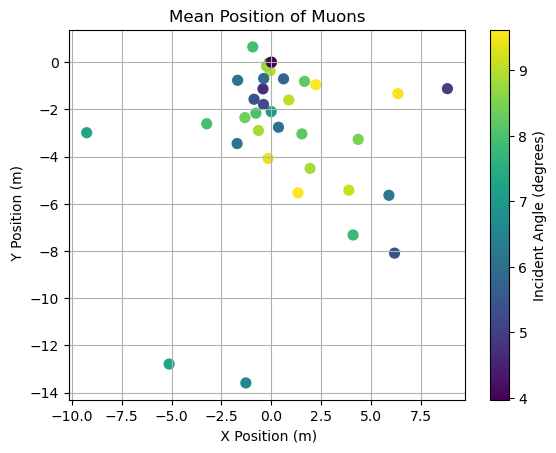

[ 17  22  39  47  53  55  83  86  94 128 129 138 186 197 200 207 218 249
 270 274 303 332 334 363 366 373 385 398 420 440 450 456 464 489 505 523
 524 525 553]


In [75]:
#log scale color bar
mask = np.where((X**2 + Y**2 < 1500**2)&(Energy_data>1e2)&(Z_deg<10))  # Mask for points within a circle of radius 15    
import matplotlib.colors as mcolors
plt.scatter(X[mask]/1e2, Y[mask]/1e2, c = Z_deg[mask], cmap='viridis', s=50)#, norm=mcolors.LogNorm())
#plt.xlim(-15, 15)
#plt.ylim(-15, 15)
plt.colorbar(label='Incident Angle (degrees)')
plt.xlabel(' X Position (m)')
plt.ylabel(' Y Position (m)')
plt.title('Mean Position of Muons')
plt.grid()
plt.show()
print(ID_valid[mask])

In [76]:
def get_parameters(filename, line_number):
    """
    Get E, h, z from a specific line number (1-based, excluding header)
    """
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Skip header (line 0) and get the requested line
    data_line_index = line_number  # line_number is already 1-based for data
    
    if data_line_index >= len(lines):
        raise IndexError(f"Line {line_number} not found. File has {len(lines)-1} data lines.")
    
    # Parse the line
    line = lines[data_line_index].strip()
    energy, height, zenith = line.split()
    
    return float(energy), float(height), float(zenith)

# Usage
filename = "/uufs/chpc.utah.edu/common/home/u1520754/corsika_inputs/sampled_muon_parameters.txt"
H = []
Z = []
A = []
for i in ID_valid[mask]+1:
    E, h, z = get_parameters(filename, i)
    gen_radi = 1500  # Example value, adjust as needed
    particle = 6  # Example value, adjust as needed
    id = i-1
    input_files =  f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
    T_photon, x_base, y_base, w, Zem, cos_x, cos_y, azimuth_event_degree, zenith_event_degree = extract_data_from_file(input_files, atmos, R=float(gen_radi), 
                                                                        tele_id=0,
                                                                        filter=False, 
                                                                        optics=False, 
                                                                        shower_coordinates=False,
                                                                        use_brightness_pixel=False,
                                                                        zenith_tele=0, azimuth_tele=0
                                                                        )
    #print(f"Line {i}: E={E} GeV, h={h/1e5} km, zenith={z}°, azimuth={360+azimuth_event_degree}°")
    H.append(h)
    Z.append(z)
    A.append(360+azimuth_event_degree)

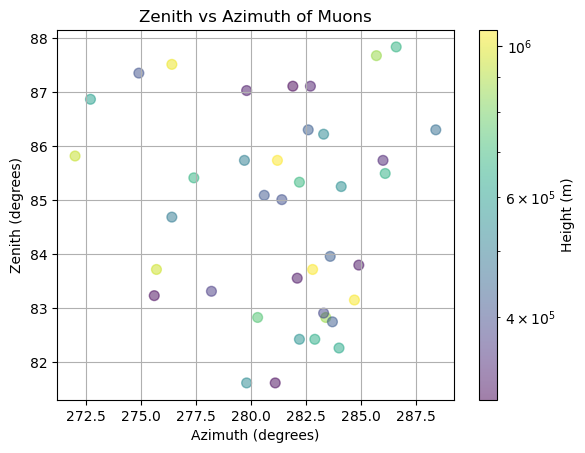

In [77]:
plt.scatter(A, Z, c=H, alpha=0.5, s=50, cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='Height (m)')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Zenith (degrees)')
plt.title('Zenith vs Azimuth of Muons')
plt.grid()
plt.show()

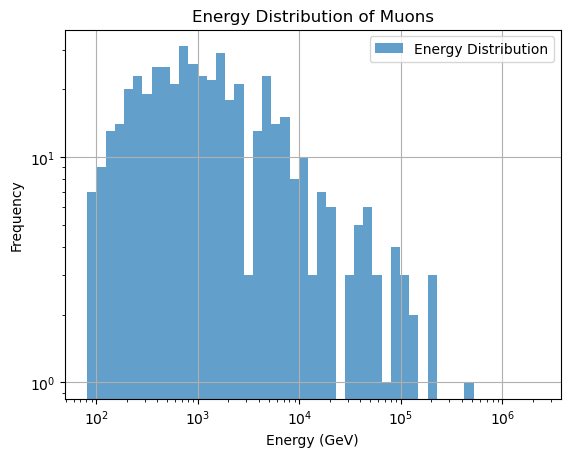

In [37]:
energy_bins = np.logspace(np.log10(np.min(Energy_data)), np.log10(np.max(Energy_data)), 50)
plt.hist(Energy_data, bins=energy_bins, alpha=0.7, label='Energy Distribution')
plt.yscale('log')  # Set y-axis to logarithmic scale for better visibility
plt.xscale('log')  # Set x-axis to logarithmic scale for better visibility
plt.xlabel('Energy (GeV)')
plt.ylabel('Frequency')
plt.title('Energy Distribution of Muons')
plt.legend()
plt.grid(True)
plt.show()

Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
Brightness pixel location in cm: (210.00, -450.00) with value 1187.00
Brightness pixel location in cm: (-15.00, 3.00) with value 120.00
Number of photons in event after optics only: 15 of 31924 Ratio: 0.00046986593158752037
[1.95018181] [-4.49931224]
8.92728596127052 1.1596853851073856 157.43465673988138 1.1793231531038617
Number of valid photons: 15
Energy [2806.6748]


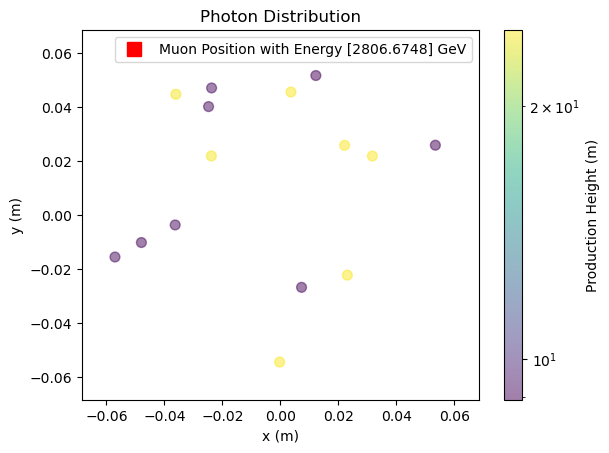

283.40002 82.82828


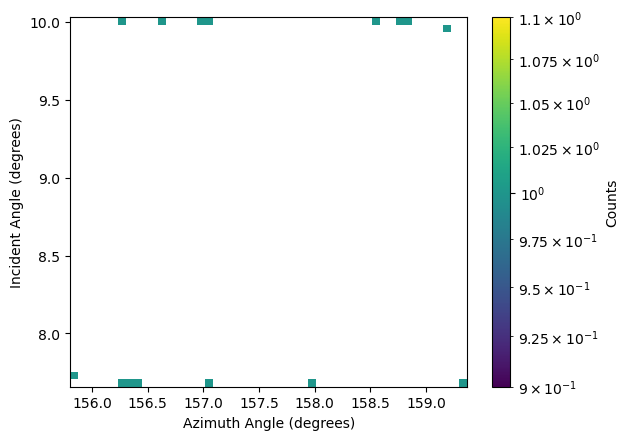

In [80]:
from eventio import IACTFile
import numpy as np
from read_telescope import VAtmosAbsorption, extract_data_from_file, filter_photons, simulate_davies_cotton_optics, read_particle_file, convert_coordinates_to_shower
from camera_response import noise_function, camera_response_function
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from matplotlib import colors as mcolors
def get_where_muon_landed(id, gen_radi = "1500", particle = 6, zenith_tele = 91, azimuth_tele = 280):
    file_path = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/DAT00{1000+id}"

    particle_list = [1,2,3,4,5, 6]  # List of particles to read

    PP = read_particle_file(file_path, particle_list)
    #id, x, y,t, E, direction_vector = pp[0], pp[4], pp[5], pp[6], pp[7]
    P_id = [pp[0] for pp in PP]
    x = [pp[1] for pp in PP]
    y = [pp[2] for pp in PP]
    t = [pp[3] for pp in PP]
    E = [pp[4] for pp in PP]
    E_all = E
    direction_vector = [pp[5] for pp in PP]
    cos_x = [pp[5][0] for pp in PP]
    cos_y = [pp[5][1] for pp in PP]
    tele_radi_temp = float(gen_radi)
    zenith_rad = np.radians(zenith_tele)
    azimuth_rad = np.radians(azimuth_tele)  # Assuming azimuth angle is 0 for simplicity
    x = np.array(x) #-  tele_radi_temp * np.tan(zenith_rad)*np.cos(azimuth_rad) 
    y = np.array(y) #- tele_radi_temp * np.tan(zenith_rad)*np.sin(azimuth_rad)
    cos_x = np.array(cos_x)
    cos_y = np.array(cos_y)
    #file = f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
    """with IACTFile(file) as streamer:
        events = iter(streamer)
        event = next(events)
        telescope_position0 = streamer.telescope_positions[0]
        #telescope_position1 = streamer.telescope_positions[1]
    x = x - telescope_position0[0]#(telescope_position1[0]-telescope_position0[0])  # Offset x position by telescope position
    y = y - telescope_position0[1]#(telescope_position1[1]-telescope_position0[1])  # Offset y position by telescope position"""
    x, y, cos_x, cos_y = convert_coordinates_to_shower(x, y, cos_x, cos_y, azimuth_rad=np.radians(-azimuth_tele), zenith_deg=zenith_tele)
    try:
        mask = np.where(E==max(E)) 
        x = x[mask]
        y = y[mask]
        cos_x = cos_x[mask]
        cos_y = cos_y[mask]
        E_max = np.array(E)[mask]
        t = np.array(t)[mask]
        cos_z = np.sqrt(1 - cos_x**2 - cos_y**2)  # Calculate cos(z) from cos(x) and cos(y)
        phi = np.arctan2(cos_y, cos_x)  # Calculate azimuth angle
        phi_deg = np.degrees(phi)  # Convert azimuth angle to degrees
        theta_z_deg = np.degrees(np.arccos(cos_z))
        return x,y,theta_z_deg, E_max,t, phi_deg, E_all
    except ValueError:
        return None, None, None, None, None, None, None

id = 17
ID = [id]
# Define the parameters
particle = 6  # 5 is mu+, 6 is mu-
gen_radi = "1500"  # telescope radius in cm, available:  1500 cm
input_files =  f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+id}/telescope.dat"
atmabs_file="/uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat"
ran_val = random.randint(0, 10000)  # Random seed for reproducibility_3
atmos = VAtmosAbsorption(model="CORSIKA", seed=ran_val, source_file=atmabs_file)
# Extract data from the files
zenith = 91
azimuth = 280
T_photon, x_base, y_base, w, Zem, cos_x, cos_y, azimuth_event_degree, zenith_event_degree = extract_data_from_file(input_files, atmos, R=float(gen_radi), 
                                                                        tele_id=0,
                                                                        filter=False, 
                                                                        optics=True, 
                                                                        shower_coordinates=True,
                                                                        use_brightness_pixel=True,
                                                                        zenith_tele=zenith, azimuth_tele=azimuth
                                                                        )
try:
    x_muon, y_muon, theta_z_deg, E, t, phi_deg, E_all = get_where_muon_landed(ID[0], gen_radi = gen_radi,
                                                                            particle = particle,
                                                                            zenith_tele = zenith,
                                                                            azimuth_tele = azimuth)
    print(x_muon/100, y_muon/100)
    plt.plot(x_muon/100, y_muon/100, 's', c='red', markersize=10, label=f'Muon Position with Energy {E} GeV')
except TypeError:
    pass
cos_z = np.sqrt(1 - cos_x**2 - cos_y**2)  # Calculate cos(z) from cos(x) and cos(y)
incident_angle = np.degrees(np.arccos(cos_z))  # Convert zenith angle to degrees
azimuth_event = np.degrees(np.arctan2(cos_y, cos_x))  # Calculate azimuth angle
print(np.mean(incident_angle), np.std(incident_angle), np.mean(azimuth_event), np.std(azimuth_event))
gen_radi = max([max(abs(x_base)), max(abs(y_base))])*1.2  # Get the maximum radius from the photon positions
Production_height = Zem/100
plt.scatter(x_base/100, y_base/100, c=Production_height, alpha=0.5, s=50, cmap='viridis', norm=mcolors.LogNorm())
print("Number of valid photons:", len(x_base))
print("Energy",E)
plt.colorbar(label='Production Height (m)')
plt.ylabel('y (m)')
plt.xlabel('x (m)')
plt.xlim(-float(gen_radi)/100, float(gen_radi)/100)
plt.ylim(-float(gen_radi)/100, float(gen_radi)/100)
plt.title(f'Photon Distribution')
plt.legend()
plt.show()
print(azimuth_event_degree+360, zenith_event_degree)
plt.hist2d(azimuth_event, incident_angle, bins=50, cmap='viridis', norm=mcolors.LogNorm())
plt.colorbar(label='Counts')
plt.xlabel('Azimuth Angle (degrees)')
plt.ylabel('Incident Angle (degrees)')
plt.show()

IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1120/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1121/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1122/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1123/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1124/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r1500.0_Trinity_MC_E3/out_sib23d-pId6/OUTPUT_1125/telescope.dat
  n_telescopes=2
)
IACTFile(
  path=/uufs

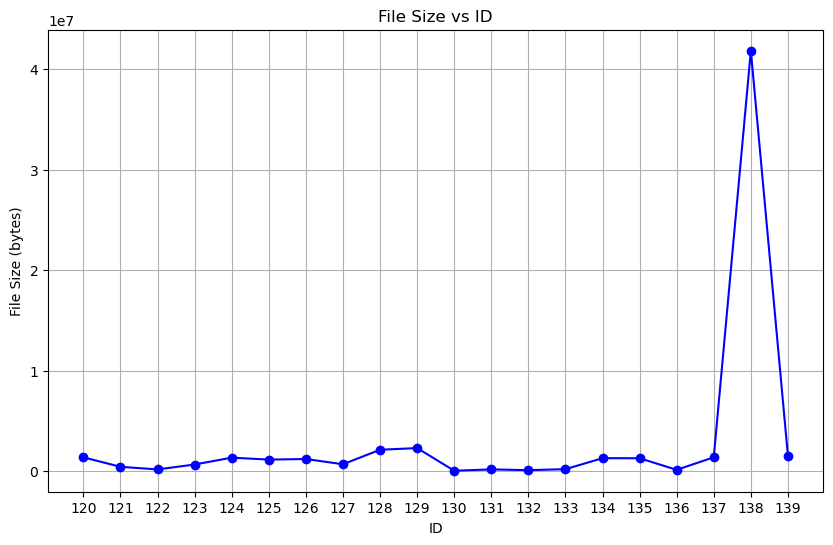

In [31]:
from read_telescope import VAtmosAbsorption, extract_data_from_file, filter_photons, simulate_davies_cotton_optics, read_particle_file, convert_coordinates_to_shower
from camera_response import noise_function, camera_response_function
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm
from eventio import IACTFile

File_Size = []
ID_data = range(120, 140)  # IDs to iterate over
error_id = []
for id in ID_data:
    ID = [id]
    # Define the parameters
    zenith = 88  #  available: 0 30 60 88 degrees
    E_mag = 6  # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
    particle = 6  # 5 is mu+, 6 is mu-
    production_height = "20.E5"  # available: 10.E5 20.E5 cm
    gen_radi = "1500"  # telescope radius in cm, available:  1500 cm
    input_files = [
            f"/uufs/chpc.utah.edu/common/home/u1520754/corsika_results/notch_r{gen_radi}.0_Trinity_MC_E3/out_sib23d-pId{particle}/OUTPUT_{1000+i}/telescope.dat"
            for i in ID
        ]
    file = input_files[0]
    #check file size:
    import os
    file_size = os.path.getsize(file)
    File_Size.append(file_size)
    try:
        with IACTFile(file) as streamer:
            print(streamer)
            events = iter(streamer)
            event = next(events)
            #print(streamer.telescope_positions[0])
    except Exception as e:
        print(f"Error processing ID {id}: {e}")
        error_id.append(id)
print(f"Error IDs: {error_id}")
plt.figure(figsize=(10, 6))
plt.plot(ID_data, File_Size, marker='o', linestyle='-', color='b')
plt.title('File Size vs ID')
plt.xlabel('ID')
plt.ylabel('File Size (bytes)')
plt.xticks(ID_data)  # Set x-ticks to match IDs
plt.grid()
plt.show()
#250, 253, 255, 476, 478, 479, 482, 483, 484, 486, 487, 490, 520, 521, 522, 523

In [ ]:

Pro_Height = [ "10.E5"] #"5.E5", "10.E5", "15.E5", "20.E5", "25.E5","30.E5"
zenith = [88]  # Zenith angles in degrees
Events_Data = [] 
E_mag = 3 # available: 1.00E6, 1.00E5, 1.00E4, 1.00E3, 1.00E1 GeV
particle = 6 #particle id 
gen_radi = "15000" #cm
for z in zenith:
    Num_triggered_events = []
    for height in Pro_Height:
        Data_id = Monte_Carlos_Avg(z, production_height=height, gen_radi=gen_radi, noise=True, E_mag=E_mag, particle=particle, N=2)
        Data_id = np.array(Data_id)
        height_float = float(height.replace("E", "e")) / 1e5 # Convert to km
        Num_triggered_events.append((height_float, Data_id))
    Events_Data.append((z, Num_triggered_events))



Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
Number of photons in event 0: 73005
Brightness pixel location in cm: (3150.00, 8250.00) with value 1097.00
Brightness pixel location in cm: (135.00, 45.00) with value 86.00
Brightness pixel location in cm: (-4.50, -1.50) with value 5.00
Total shift in cm: (3280.50, 8293.50)
Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
Number of photons: 168
Number of photons after filtering: 46
Atmospheric extinction model: CORSIKA
VAtmosAbsorption: reading atmospheric extinction file (from CORSIKA): /uufs/chpc.utah.edu/common/home/u1520754/corsika-78010/run/atmabs.dat
Number of photons in event 0: 75251
Brightness pixel location in cm: (1950.00, 5850.00) with value 1090.00
Brightness pixel locati

In [14]:
#Store Events Data to pickle file
import pickle
with open(f'Events_Data_1E{E_mag}_pid{particle}_88.pickle', 'wb') as f:
    pickle.dump(Events_Data, f)

5000


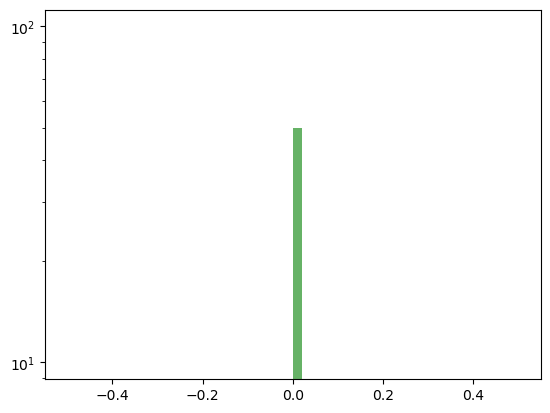

In [15]:
#Read pickle file
E_mag = 4
particle = 6
with open(f'Events_Data_1E{E_mag}_pid{particle}_88.pickle', 'rb') as f:
    Events_Data2 = pickle.load(f)
x = list(Events_Data2) # Convert to list for easier manipulation
x = np.array(x, dtype=object)  # Convert to numpy array for easier manipulation
zenith_angles = x[:, 0]  # Extract zenith angles
Pro_Height_float = [np.array([i[0] for i in x[1]]) for x in x]  # Extract production heights in km
Num_triggered_events = [([i[1] for i in x[1]]) for x in x]  # Extract number of events per production height
import numpy as np
from scipy.stats import binom, poisson

# Example list of PE counts for 10 events
def calculate_pe_statistics(pe_counts):
    pe_counts = np.array(pe_counts)
    threshold = 20
    N = len(pe_counts)
    k = sum(np.array(pe_counts) >= threshold)
    p_hat = k / N

    # Binomial (Clopper-Pearson) 95% confidence interval
    alpha = 0.05
    ci_low, ci_high = binom.interval(1 - alpha, N, p_hat, loc=0)
    ci_low /= N
    ci_high /= N

    # Poisson modeling of PE counts
    lambda_hat = np.mean(pe_counts)
    p_det_poisson = 1 - poisson.cdf(threshold - 1, lambda_hat)
    return p_det_poisson

# Example usage:
pe_counts = Num_triggered_events[0][6]
plt.hist(pe_counts, bins=50, density=True, alpha=0.6, color='g', label='PE Counts Distribution')
plt.yscale('log')
print(len(pe_counts))

Production Height: 40.0 km, Detection Probability: 0.0200, CI: 0.0000, 0.0500


/tmp/ipykernel_3090625/175370303.py:42: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



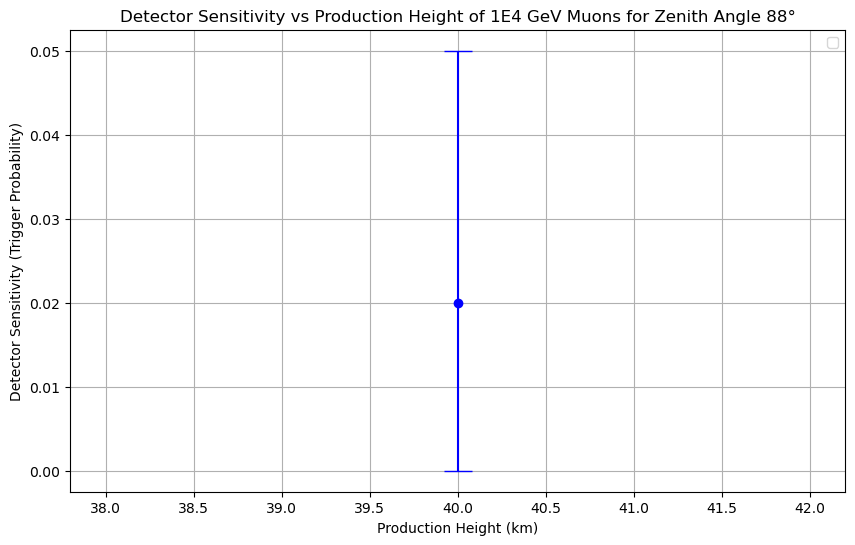

In [40]:
def detect_prob(pe_counts, j):
    pe = pe_counts[0][j]

    # Poisson-based detection probability
    p_det = len(pe[np.where(pe >= 20)])/len(pe)
    # Bootstrap CI
    rng = np.random.default_rng()
    p_boot = []
    n_bootstrap = 10000
    threshold = 20
    N = len(pe)
    alpha = 0.05
    for _ in range(n_bootstrap):
        sample = rng.choice(pe, size=N, replace=True)
        p_b = len(sample[np.where(sample >= threshold)])/len(sample)
        p_boot.append(p_b)
    lower = p_det - np.percentile(p_boot, 100 * alpha/2)
    upper = np.percentile(p_boot, 100 * (1 - alpha/2)) - p_det
    ci_bootstrap = (lower, upper)
    return p_det, ci_bootstrap
plt.figure(figsize=(10, 6))
x_data = []
y_data = []
y_err = []
x = list(Events_Data) # Convert to list for easier manipulation
x = np.array(x, dtype=object)  # Convert to numpy array for easier manipulation
zenith_angles = x[:, 0]  # Extract zenith angles
Pro_Height_float = [np.array([i[0] for i in x[1]]) for x in x]  # Extract production heights in km
Num_triggered_events = [([i[1] for i in x[1]]) for x in x]  # Extract number of events per production height
for j in range(len(Pro_Height_float[0])):
    mean_prob, ci_bootstrap = detect_prob(Num_triggered_events, j)
    print(f"Production Height: {Pro_Height_float[0][j]} km, Detection Probability: {mean_prob:.4f}, CI: {mean_prob-ci_bootstrap[0]:.4f}, {mean_prob+ci_bootstrap[1]:.4f}")
    x_data.append(Pro_Height_float[0][j])
    y_data.append(mean_prob)
    y_err.append(ci_bootstrap)
    #plt.errorbar(Pro_Height_float[0][j], mean_prob, yerr=[[ci_bootstrap[0]], [ci_bootstrap[1]]], fmt='--o', capsize=10, color='b', label=f'Height: {Pro_Height_float[0][j]} km')
plt.errorbar(x_data, y_data, yerr=np.array(y_err).T, fmt="--o", color='b', capsize=10)
plt.xlabel('Production Height (km)')
plt.ylabel('Detector Sensitivity (Trigger Probability)')
plt.title(f'Detector Sensitivity vs Production Height of 1E{E_mag} GeV Muons for Zenith Angle 88°')
#plt.ylim([0, 1])  # Set y-axis limits to [0, 1]
plt.legend()
plt.grid()   

In [190]:
Pro_Height = ["5.E5", "10.E5", "15.E5", "20.E5", "25.E5","30.E5", "40.E5"] #
zenith = [80, 81, 82, 83, 84, 85, 86, 87, 88]  # Zenith angles in degrees  
Events_Data = []
for z in zenith:
    Num_triggered_events = []
    for height in Pro_Height:
        Data_id = []
        for id in range(1, 11):
            h, H, Times, Noise = plot(z, id, production_height=height, noise=True)
            if h is None:
                Trigger_events = 0  # No events triggered
            else:
                Trigger_events = h.max()  # Sum of all pixels with at least 20 PEs
            Data_id.append(Trigger_events)
        height_float = float(height.replace("E", "e")) / 1e5 # Convert to km
        Num_triggered_events.append((height_float, Data_id))
    Events_Data.append((z, Num_triggered_events))

Number of photons in event 0: 248821
Bright pixel location in cm: (-615.00, -135.00) with value 200.00
Number of photons in event after optics only 0: 900 of 248821 Ratio: 0.0036170580457437276
Number of photons: 900
Number of photons after filtering: 90
Number of photons after filtering only: 90 of 248821 Ratio: 0.00036170580457437276
Number of photons in event 0: 1241939
Bright pixel location in cm: (-135.00, -195.00) with value 1444.00
Number of photons in event after optics only 0: 22380 of 1241939 Ratio: 0.018020208722006475
Number of photons: 22380
Number of photons after filtering: 2218
Number of photons after filtering only: 2218 of 1241939 Ratio: 0.0017859170216894711
Number of photons in event 0: 74731
Bright pixel location in cm: (-705.00, 405.00) with value 203.00
Number of photons in event after optics only 0: 443 of 74731 Ratio: 0.005927928169032932
Number of photons: 443
Number of photons after filtering: 37
Number of photons after filtering only: 37 of 74731 Ratio: 0.00

/uufs/chpc.utah.edu/common/home/u1520754/test_jupyter/read_telescope.py:544: RuntimeWarning:

invalid value encountered in sqrt



Number of photons after filtering: 1529
Number of photons after filtering only: 1529 of 1180526 Ratio: 0.0012951853665230583
Number of photons in event 0: 2288091
Bright pixel location in cm: (-255.00, -105.00) with value 1035.00
Number of photons in event after optics only 0: 16533 of 2288091 Ratio: 0.007225674153694062
Number of photons: 16533
Number of photons after filtering: 1377
Number of photons after filtering only: 1377 of 2288091 Ratio: 0.0006018117286419115
Number of photons in event 0: 77102
Bright pixel location in cm: (255.00, 195.00) with value 148.00
Number of photons in event after optics only 0: 444 of 77102 Ratio: 0.0057586054836450415
Number of photons: 444
Number of photons after filtering: 29
Number of photons after filtering only: 29 of 77102 Ratio: 0.00037612513294077974
Number of photons in event 0: 1935229
Bright pixel location in cm: (-135.00, -195.00) with value 9477.00
Number of photons in event after optics only 0: 106707 of 1935229 Ratio: 0.05513921091509

/uufs/chpc.utah.edu/common/home/u1520754/test_jupyter/read_telescope.py:539: RuntimeWarning:

invalid value encountered in sqrt



Bright pixel location in cm: (-285.00, -465.00) with value 2614.00
Number of photons in event after optics only 0: 37111 of 3034260 Ratio: 0.012230659205209837
Number of photons: 37111
Number of photons after filtering: 758
Number of photons after filtering only: 758 of 3034260 Ratio: 0.00024981379314890613
Number of photons in event 0: 8423
Bright pixel location in cm: (-285.00, -465.00) with value 131.00
Number of photons in event after optics only 0: 622 of 8423 Ratio: 0.0738454232458744
Number of photons: 622
Number of photons after filtering: 8
Number of photons after filtering only: 8 of 8423 Ratio: 0.000949780363290989
Number of photons in event 0: 1038761
Bright pixel location in cm: (-285.00, -465.00) with value 3695.00
Number of photons in event after optics only 0: 47692 of 1038761 Ratio: 0.04591238985676205
Number of photons: 47692
Number of photons after filtering: 951
Number of photons after filtering only: 951 of 1038761 Ratio: 0.0009155137707326324
Number of photons in 

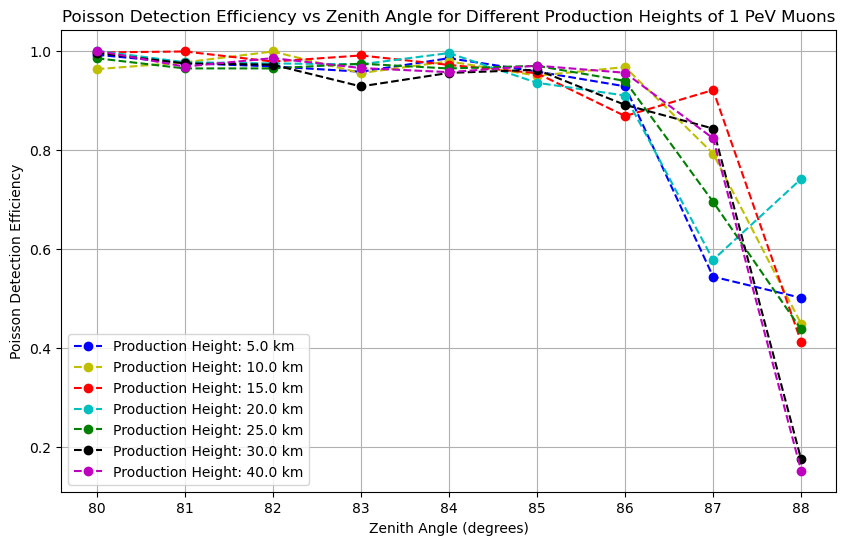

In [271]:
import matplotlib.pyplot as plt
colors = ['b', 'y', 'r', 'c', 'g', 'black', 'm']  # Define colors for each zenith angle
Count =[[calculate_pe_statistics(i) for i in Num_triggered_events[j]]  for j in range(len(zenith_angles))] # Example to test median calculation
Count = np.array(Count)
plt.figure(figsize=(10, 6))
for i, height in enumerate(Pro_Height_float[0]):
    plt.plot(zenith_angles, Count[:,i], "--o", color=colors[i], label=f'Production Height: {height} km')
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Poisson Detection Efficiency')
plt.legend()
plt.grid()
#plt.yscale('log')  # Use logarithmic scale for better visibility
plt.title('Poisson Detection Efficiency vs Zenith Angle for Different Production Heights of 1 PeV Muons')
plt.show()

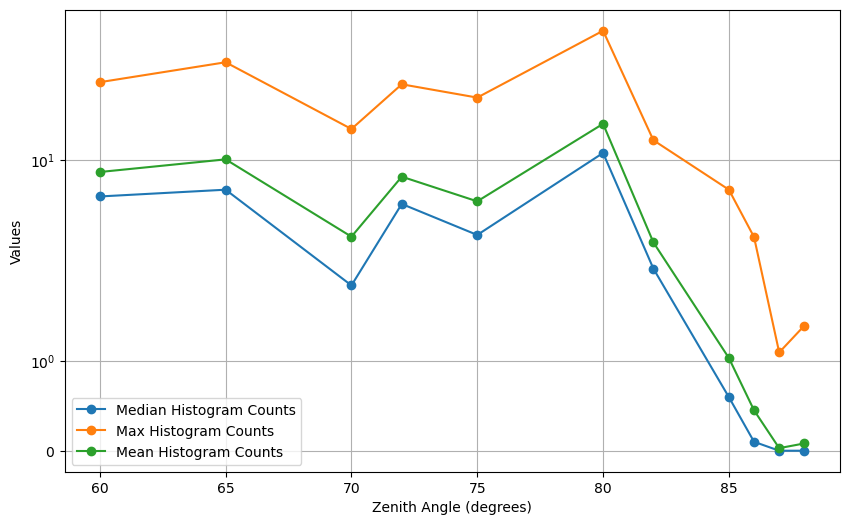

In [92]:
#I want to have the error bar representing thr min and max values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(zenith, H[:, 0], marker='o', label='Median Histogram Counts')
plt.plot(zenith, H[:, 1], marker='o', label='Max Histogram Counts')
plt.plot(zenith, H[:, 2], marker='o', label='Mean Histogram Counts')
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.yscale('symlog')  # Use logarithmic scale for better visibility
plt.show()

Exception ignored in: <function EventIOFile.__del__ at 0x14d54be13a60>
Traceback (most recent call last):
  File "/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/eventio/base.py", line 157, in __del__
    self.close()
  File "/uufs/chpc.utah.edu/common/home/u1520754/miniconda3/envs/jupyter_env/lib/python3.9/site-packages/eventio/base.py", line 154, in close
    self._filehandle.close()
AttributeError: 'IACTFile' object has no attribute '_filehandle'


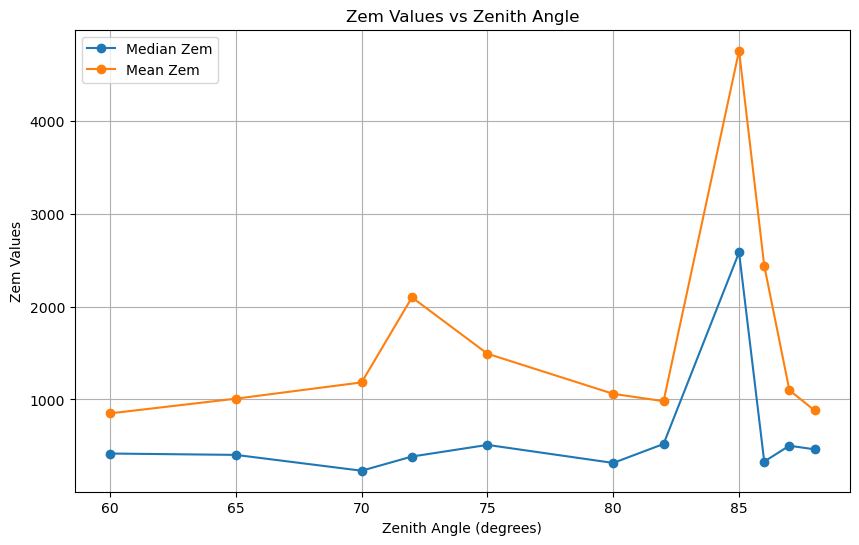

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(zenith, Z[:, 0], marker='o', label='Median Zem')
#plt.plot(zenith, Z[:, 1], marker='o', label='Max Zem')
plt.plot(zenith, Z[:, 2], marker='o', label='Mean Zem')
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Zem Values')  
#plt.yscale('log')  
plt.grid()
plt.legend()
plt.title('Zem Values vs Zenith Angle')
plt.show()

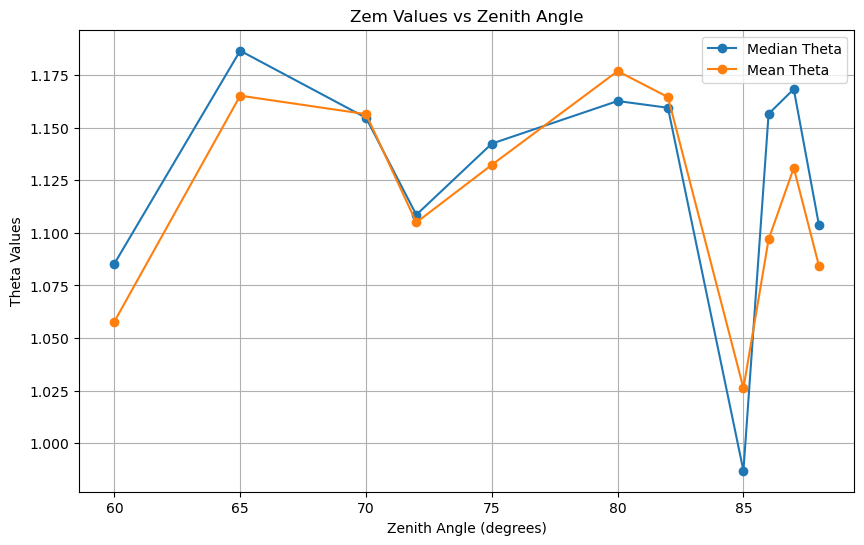

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(zenith, Theta[:, 0], marker='o', label='Median Theta')
#plt.plot(zenith, Theta[:, 1], marker='o', label='Max Theta')
plt.plot(zenith, Theta[:, 2], marker='o', label='Mean Theta')
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Theta Values')  
#plt.yscale('log')  
plt.grid()
plt.legend()
plt.title('Zem Values vs Zenith Angle')
plt.show()